In [1]:
%pip install networkx

  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from functools import partial
from pathlib import Path

import numpy as np
import networkx as nx
import pandas as pd

from biosynfoni.inoutput import *


/var/folders/qm/fzt72bc53hq6hhbj3wfljp5w0000gn/T/ipykernel_14694/1869458995.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [67]:

def extract_linestartswith(
    lines: list, starts: list = [], remove_starts: bool = True, strip_extra: str = " - "
) -> dict[list[str]]:
    """
    Extracts lines starting with terms in starts, returning them as a list to accomodate multiple values per entry

        Args:
            lines (list): list of strings
            starts (list): list of strings to search for at the start of each line
            remove_starts (bool): whether to remove the start of the line
            strip_extra (str): string to strip from the start of the line
        Returns:
            dict: dictionary with starts as keys and lists of strings as values

    Remark:
        within a collection of lines, only extracts the lines starting with
        terms in starts, returning them as a list to accomodate multiple values
        per entry
    """
    extraction = {}
    for start in starts:
        extraction[start] = []
    for line in lines:
        for start in starts:
            if line.startswith(f"{start} "): # to avoid ones not exactly starting with start
                extraction[start].append(
                    line.strip().replace(start, "").replace(strip_extra, "").strip()
                )
    return extraction


def info_from_entries(
    info_loc: str,
    info2extract: list[str],
    ignore_start: str = "#",
    entry_sep="//",
    encoding="iso8859-1",
    remove_starts=True,
    strip_extra: str = " - ",
) -> pd.DataFrame:
    """
    Extracts information from entries in a file

        Args:
            info_loc (str): location of file
            info2extract (list): list of strings to search for at the start of each line
            ignore_start (str): ignore lines starting with this string
            entry_sep (str): separator for entries
            encoding (str): file encoding
            remove_starts (bool): whether to remove the start of the line
            strip_extra (str): string to strip from the start of the line
        Returns:
            pd.DataFrame: dataframe with info2extract as columns

    Remark:
        within a collection of lines, only extracts the lines starting with
        terms in starts, returning them as a list to accomodate multiple values
        per entry
    """
    entries = entry_parser(
        readr(info_loc, ignore_start=ignore_start, encoding=encoding), sep=entry_sep
    )

    all_vals = per_entry(
        entries,
        extract_linestartswith,
        starts=info2extract,
        remove_starts=remove_starts,
        strip_extra=strip_extra,
    )
    df = pd.DataFrame.from_records(all_vals)

    return df


get_pathways = partial(
    info_from_entries,
    info2extract=[
        "UNIQUE-ID",
        "REACTION-LIST",
        "SPECIES",
        "TAXONOMIC-RANGE",
        "REACTION-LAYOUT",
    ],
)
get_compounds = partial(
    info_from_entries,
    info2extract=["UNIQUE-ID", "SMILES", "INCHI", "NON-STANDARD-INCHI"],
)


def _lower_dunder(df: pd.DataFrame) -> pd.DataFrame:
    """Converts column names to lowercase and replaces - with _"""
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("-", "_")
    return df


def _remove_empties(
    df: pd.DataFrame, subset: list[str] = ["left", "right"]
) -> pd.DataFrame:
    """Removes empty strings from subset columns"""
    df = df.replace(r"^\s*$", np.nan, regex=True)
    df = df.dropna(subset=subset)
    return df


def _remove_water(
    df: pd.DataFrame, subset: list[str] = ["left", "right"], water_str: str = "WATER"
) -> pd.DataFrame:
    """Removes water from subset columns"""
    for colname in subset:
        df[colname] = df[colname].str.replace(water_str, "")
    return df


def _filter_by_num_reactions(
    df: pd.DataFrame, min_num: int = 4, reaction_list_col="reaction_list"
) -> pd.DataFrame:
    """Filters dataframe by minimum number of reactions in reaction_list_col"""
    df = df[df[reaction_list_col].str.len() >= min_num]
    return df


def _listcell_to_strcell(df: pd.DataFrame, colname: str) -> pd.DataFrame:
    """Converts list cell to string cell"""
    assert df[df[colname].str.len() > 1].empty, "error, multiple values in cell"
    df[colname] = df[colname].str[0]
    return df


def _rename_col(df: pd.DataFrame, old: str, new: str) -> pd.DataFrame:
    """Renames column in dataframe"""
    df.rename(columns={old: new}, inplace=True)
    return df


def _df_get_all_rxn_layouts(
    df: pd.DataFrame, column_name: str = "reaction_layout"
) -> pd.DataFrame:
    """
    Splits the reaction-layout column into reaction-id, left, direction, right

        Args:
            df (pd.DataFrame): dataframe with reaction-layout column
            column_name (str): name of the reaction-layout column
        Returns:
            pd.DataFrame: dataframe with reaction-layout column split into reaction-id, left, direction, right
    Remark:
        - specific to pathway-tools dataframe format (metacyc pathway file)
    """
    # first get separate entry for each REACTION-LAYOUT
    df = df.explode(column_name)
    df["reaction_id"] = df[column_name].str.split(" ", expand=True)[0].str.strip("(")
    df["left"] = (
        df[column_name]
        .str.split(":", expand=True)[1]
        .str.replace("LEFT-PRIMARIES", "")
        .str.strip(") (")
    )
    df["direction"] = df[column_name].str.split(":", expand=True)[3].str.strip(") (")
    df["right"] = (
        df[column_name]
        .str.split("RIGHT-PRIMARIES", expand=True)[1]
        .str.strip("))")
        .str.strip()
    )
    return df


def _switch_directions(
    df: pd.DataFrame, subset: tuple[str] = ("left", "right"), on: str = "direction"
) -> pd.DataFrame:
    """
    Switch left and right columns if direction is R2L

        Args:
            df (pd.DataFrame): dataframe with left, right, direction columns
            subset (tuple): tuple of strings for left and right column names
            on (str): name of the direction column
        Returns:
            pd.DataFrame: dataframe with left and right columns switched if direction is R2L

    """
    left, right = subset
    df[left], df[right] = np.where(
        df[on] == "R2L", (df[right], df[left]), (df[left], df[right])
    )
    df[on] = df[on].str.replace("R2L", "L2R")
    return df



def clean_pw_df(
    df: pd.DataFrame, min_num: int = 4, reaction_list_col="reaction_list"
) -> pd.DataFrame:
    """Cleans pathway dataframe"""
    df = _lower_dunder(df)
    df = _df_get_all_rxn_layouts(df, column_name="reaction_layout")
    df = _switch_directions(df, subset=["left", "right"], on="direction")
    df = _remove_water(df, subset=["left", "right"])
    df = _remove_empties(df, subset=["left", "right"])
    df = _filter_by_num_reactions(
        df, min_num=min_num, reaction_list_col=reaction_list_col
    )
    df = _listcell_to_strcell(df, "unique_id")
    df = _rename_col(df, "unique_id", "pathway_id")
    return df

In [68]:
# input 
pathways_path = Path.home() / "article_bsf/data/raw_data/pathways.dat"
compounds_path = Path.home() / "article_bsf/data/raw_data/compounds.dat"
output_path = Path.home() / "temp/chains.csv"

# script
output_dir = os.path.abspath(os.path.dirname(output_path))
temp_dir = os.path.join(output_dir, "intermediate_files")
iwd = os.getcwd()
os.makedirs(temp_dir, exist_ok=True)
os.chdir(temp_dir)

pathway_data = clean_pw_df(get_pathways(pathways_path))

In [84]:
reaction_info = pathway_data[["reaction_id", "left","direction", "right"]]
reaction_info[reaction_info["left"].str.contains(" ")]

,reaction_id,left,direction,right
8,GALACTURIDYLYLTRANS-RXN,GALACTOSE-1P CPD-12575,L2R,GLC-1-P CPD-14553
19,TRANSALDOL-RXN,ERYTHROSE-4P FRUCTOSE-6P,L2R,GAP D-SEDOHEPTULOSE-7-P
19,1TRANSKETO-RXN,GAP D-SEDOHEPTULOSE-7-P,L2R,XYLULOSE-5-PHOSPHATE RIBOSE-5P
27,2TRANSKETO-RXN,XYLULOSE-5-PHOSPHATE ERYTHROSE-4P,L2R,GAP FRUCTOSE-6P
34,RXN-8032,ACETYL-COA GLUTARYL-COA,L2R,3-OXOPIMELOYL-COA
...,...,...,...,...
3499,THI-P-SYN-RXN,AMINO-HYDROXYMETHYL-METHYLPYRIMIDINE-PP THZ-P,L2R,THIAMINE-P
3509,RXN-15949,GLT CPD-7646,L2R,CPD-7628
3509,RXN-15947,TYRAMINE GLT,L2R,CPD-17179
3509,RXN-15945,CPD-17180 CPD-17179,L2R,CPD-7646


In [70]:
def get_pathway_graphs(pathway_data):
    pathways = {}
    for pathway_id, info in pathway_data.groupby("pathway_id"):
        pathways[pathway_id] = nx.DiGraph()
        for _, row in info.iterrows():
            pathways[pathway_id].add_edge(row["left"], row["right"], reaction_id = row["reaction_id"])
    return pathways

def get_longest_chains(pathways: dict, with_compounds: list | None = None):
    for pathway_id, pathway_graph in pathways.items():
        if not with_compounds is None:
            nodes_to_remove = [node for node in pathway_graph.nodes if node not in with_compounds]
            pathway_graph.remove_nodes_from(nodes_to_remove)
        # if graph is cyclic, iterate over all nodes to find the longest path with all_simple_paths
        if not nx.is_directed_acyclic_graph(pathway_graph):
            longest_path = []
            for node in pathway_graph.nodes:
                for path in nx.all_simple_paths(pathway_graph, source=node, target=pathway_graph.nodes):
                    if len(path) > len(longest_path):
                        longest_path = path
        else:
            longest_path = nx.dag_longest_path(pathway_graph)
        yield pathway_id, longest_path

In [79]:
compounds = get_compounds(compounds_path)
for col in compounds.columns[:2]:
    compounds = _listcell_to_strcell(compounds, col)

In [87]:



pathways = get_pathway_graphs(pathway_data)
longest_chains = dict(get_longest_chains(pathways, with_compounds=compounds["UNIQUE-ID"].tolist()))

longest_chains = dict(sorted(longest_chains.items(), key=lambda x: len(x[1]), reverse=True))

# get the edge information
# nx_graph[longest_path[i]][longest_path[i+1]]

In [88]:
len(longest_chains["PWY-8152"])

28

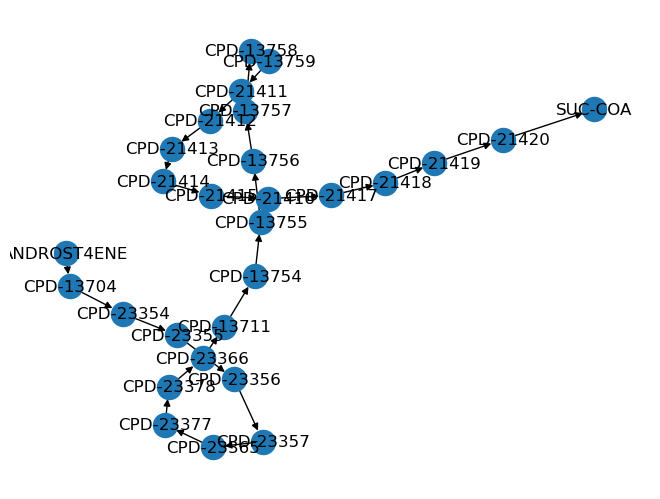

In [83]:
# draw graph
nx.draw(pathways["PWY-8152"], with_labels=True)

In [101]:
# save all the graphs
if not os.path.exists("pathway_graphs"):
    Path("pathway_graphs").mkdir(exist_ok=False)

for pathway_id, pathway_graph in pathways.items():
    nx.write_edgelist(pathway_graph, f"pathway_graphs/{pathway_id}.edgelist")

NotADirectoryError: [Errno 20] Not a directory: 'pathway_graphs/12DICHLORETHDEG-PWY.edgelist'